# Propagation Relation
S. Jones 09/07/24

Notebook designed to look at if we can extract an analytical form that can be used to quickly calculate retarded times.

In [53]:
# Some standard imports
import src.QTNMTraps as traps
import src.Particle as part
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy.optimize import curve_fit, fsolve

In [54]:
# Use Latex in figure text
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Make labels bigger
plt.rcParams.update({'font.size': 12})

## Harmonic trap
Initially look at the propagation time in a harmonic trap. We are interested in the relationship between the emission time, $t_{\text{emit}}$, and reception time, $t_{\text{receive}}$.

In [55]:
# Define a harmonic trap
B0 = 1.0  # T
L0 = 0.2  # m
# Define trap
harmonicTrap = traps.HarmonicTrap(B0, L0)

In [56]:
# Define a receiver position
zR = -0.05  # metres
receiverPosition = np.array([0.0, 0.0, zR])
pitchAngleInit = 87.0 * np.pi / 180.0

# Define electron
eKE = 18.575e3  # eV
startPos = np.array([1e-5, 0.0, 0.0])
electron = part.Particle(eKE, np.array([1e-5, 0.0, 0.0]),
                         pitchAngle=pitchAngleInit)

In [57]:
# Get the electron position as a function of time
tObs = 0.1e-6  # seconds
samplePeriod = 5e-10  # seconds
timeArray = np.arange(0, tObs, samplePeriod)
electronZPos = harmonicTrap.GetZPosTime(timeArray, electron.GetSpeed(),
                                        pitchAngleInit)
# For each point, calculate the signal arrival time
arrivalTimes = timeArray + abs(zR - electronZPos) / sc.c

# Define a shifted sine wave to fit to the above relationship
def ShiftedSine(x, A, omega, phi, yOffset):
    return A * np.sin(omega * x + phi) + yOffset

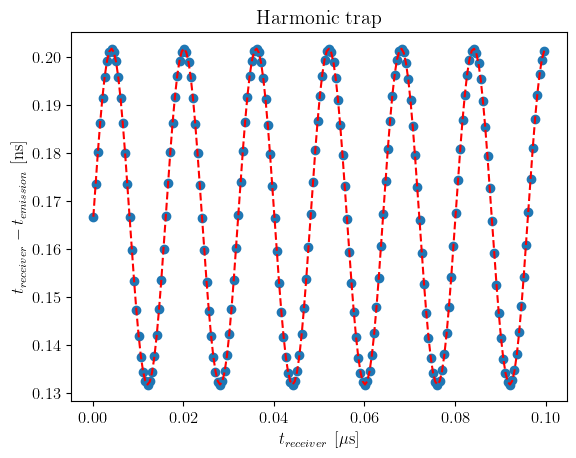

In [58]:
plt.figure()
plt.plot(arrivalTimes * 1e6, (arrivalTimes - timeArray) * 1e9, 'o')
plt.title("Harmonic trap")
plt.xlabel("$t_{receiver}$ [$\mu$s]")
plt.ylabel("$t_{receiver} - t_{emission}$ [ns]")

# Now fit the sine wave to the data
popt, pcov = curve_fit(ShiftedSine, arrivalTimes, arrivalTimes - timeArray,
                       p0=[0.01e-9, 2 * np.pi * 60e6, 0.0, 0.165e-9])
# Draw the fit
fitTimes = ShiftedSine(arrivalTimes, *popt)
plt.plot(arrivalTimes * 1e6, fitTimes * 1e9, 'r--')
plt.show()

We can actually try and compare some of the fit parameters with our guesses from where they come from.

In [59]:
# Compare parameters with calculated values
omega_a = harmonicTrap.CalcOmegaAxial(pitchAngleInit, electron.GetSpeed())
print(f"Calculated Omega_a vs. omega fit value: {omega_a:.3e} vs. {popt[1]:.3e}")
offsetCalc = abs(zR) / sc.c
print(f"Calculated offset vs. yOffset fit value: {offsetCalc:.3e} vs. {popt[3]:.3e}")
amplitudeCalc = harmonicTrap.CalcZMax(pitchAngleInit) / sc.c
print(
    f"Calculated amplitude vs. amplitude fit value: {amplitudeCalc:.3e} vs. {popt[0]:.3e}")

Calculated Omega_a vs. omega fit value: 3.930e+08 vs. 3.930e+08
Calculated offset vs. yOffset fit value: 1.668e-10 vs. 1.668e-10
Calculated amplitude vs. amplitude fit value: 3.496e-11 vs. 3.496e-11


### Moving the receiver point
Now, look at what happens if we move the receiver point in an arc.

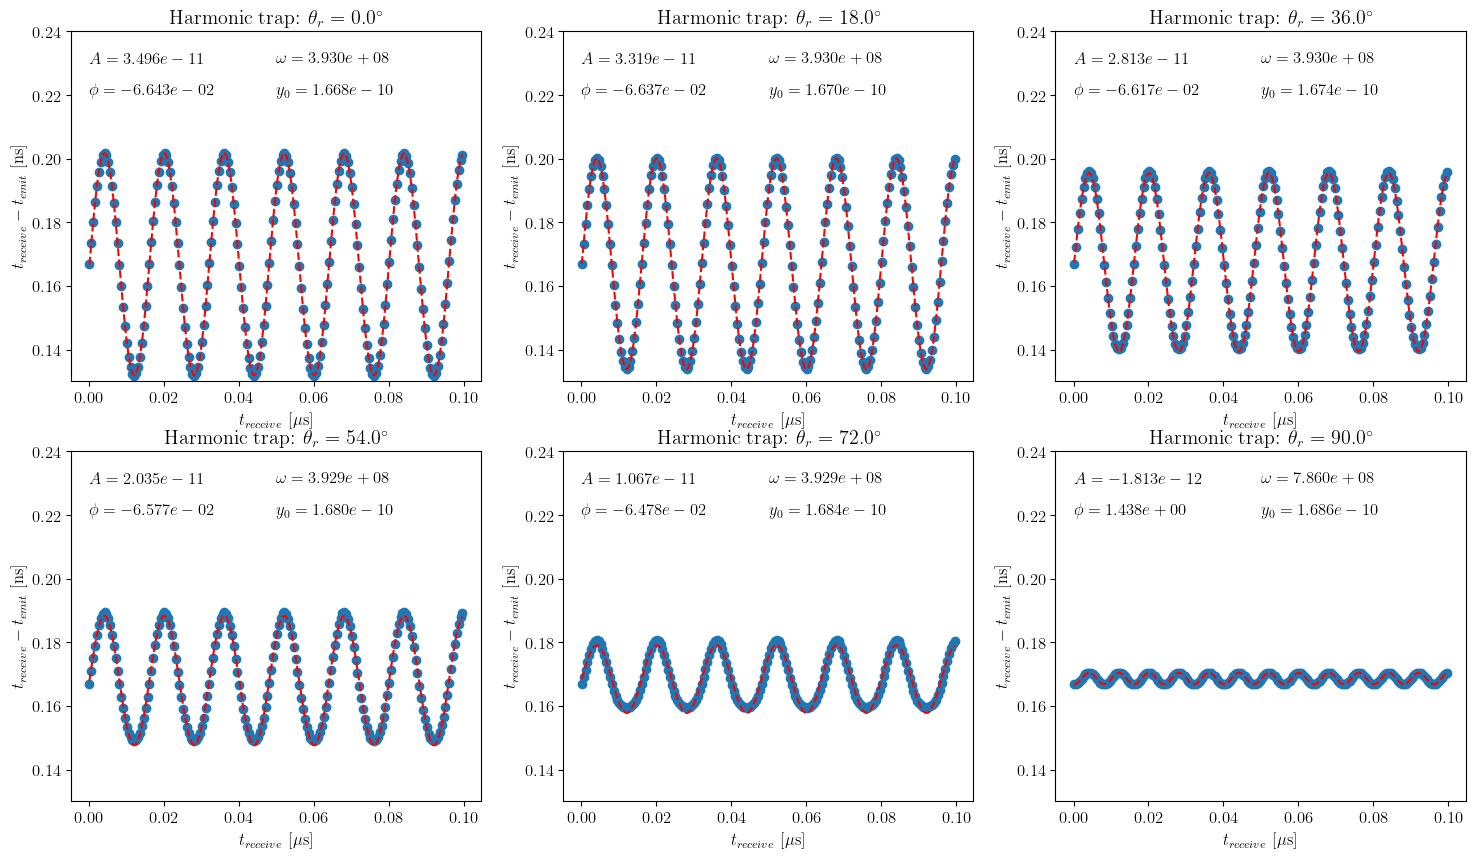

In [60]:
receiverAngles = np.linspace(0, np.pi / 2, 6)
electronPosTime = np.array([np.zeros_like(electronZPos), 
                            np.zeros_like(electronZPos), electronZPos])

plt.figure(figsize=(18, 10))
for iAng, ang in enumerate(receiverAngles):
  rAngPosition = zR * np.array([np.sin(ang), 0.0, np.cos(ang)])
  aTimesAng = np.zeros_like(timeArray)
  for it, t in enumerate(timeArray):
    electronPos = np.array([0, 0, harmonicTrap.GetZPosTime(t, electron.GetSpeed(), pitchAngleInit)])
    aTimesAng[it] = t + np.linalg.norm(rAngPosition - electronPos) / sc.c

  plt.subplot(2, 3, iAng + 1)
  plt.plot(aTimesAng * 1e6, (aTimesAng - timeArray) * 1e9, 'o',
           label=f"{ang * 180 / np.pi:.1f} deg")
  plt.title(f"Harmonic trap: $\\theta_r = {ang * 180 / np.pi:.1f}^\circ$")
  plt.xlabel("$t_{receive}$ [$\mu$s]")
  plt.ylabel("$t_{receive} - t_{emit}$ [ns]")

  # Now fit the sine wave to the data
  omegaGuess = harmonicTrap.CalcOmegaAxial(pitchAngleInit, electron.GetSpeed())
  if ang == np.pi / 2:
    omegaGuess = 2 * harmonicTrap.CalcOmegaAxial(pitchAngleInit, electron.GetSpeed()) 

  popt, pcov = curve_fit(ShiftedSine, aTimesAng, aTimesAng - timeArray,
                         p0=[0.07e-9, omegaGuess, 0.0, 
                         np.linalg.norm(rAngPosition) / sc.c])

  # Draw the fit
  fitTimes = ShiftedSine(aTimesAng, *popt)
  plt.plot(aTimesAng * 1e6, fitTimes * 1e9, 'r--')
  # Draw the fit parameters on each plote
  plt.ylim(0.13, 0.24)
  plt.text(0.0, 0.23, f"$A = {popt[0]:.3e}$")
  plt.text(0.05, 0.23, f"$\omega = {popt[1]:.3e}$")
  plt.text(0.0, 0.22, f"$\phi = {popt[2]:.3e}$")
  plt.text(0.05, 0.22, f"$y_0 = {popt[3]:.3e}$")

plt.show()

### Comparison with using ```fsolve```
Given we now have an description of the relationship between reception and emission times, we can check the performance compared with using the ```fsolve``` function.

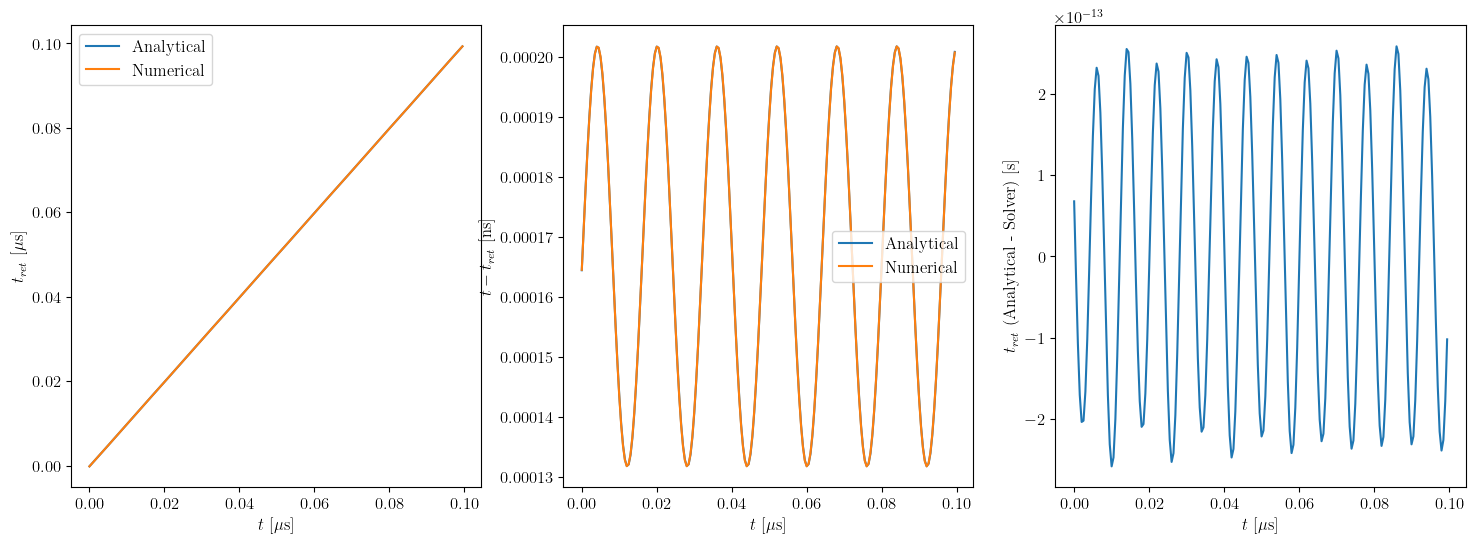

In [61]:
# Put the receiver back on the axis
arrivalTimes = timeArray + abs(zR - electronZPos) / sc.c
# Now fit the sine wave to the data
AGuess = harmonicTrap.CalcZMax(pitchAngleInit) / sc.c
omegaGuess = harmonicTrap.CalcOmegaAxial(pitchAngleInit, electron.GetSpeed())
y0Guess = abs(zR) / sc.c
popt_onAxis, pcov = curve_fit(ShiftedSine, arrivalTimes, arrivalTimes - timeArray,
                              p0=[AGuess, omegaGuess, 0.0, y0Guess])

# Now generate the retarded times using the analytical formula
tRetAna = timeArray - ShiftedSine(timeArray, *popt_onAxis)

# Now generate the retarded times using the numerical formula
tRetSolver = np.zeros_like(timeArray)
for iT, T in enumerate(timeArray):
    def func(te): return T - te - abs(zR - harmonicTrap.GetZPosTime(te, electron.GetSpeed(), pitchAngleInit)) / sc.c

    tRetSolver[iT] = fsolve(func, T)

plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.plot(timeArray * 1e6, tRetAna * 1e6, label="Analytical")
plt.plot(timeArray * 1e6, tRetSolver * 1e6, label="Numerical")
plt.xlabel("$t$ [$\mu$s]")
plt.ylabel("$t_{ret}$ [$\mu$s]")
plt.legend()

plt.subplot(132)
plt.plot(timeArray * 1e6, (timeArray - tRetAna) * 1e6, label="Analytical")
plt.plot(timeArray * 1e6, (timeArray - tRetSolver) * 1e6, label="Numerical")
plt.xlabel("$t$ [$\mu$s]")
plt.ylabel("$t - t_{ret}$ [ns]")
plt.legend()

plt.subplot(133)
plt.plot(timeArray * 1e6, tRetAna - tRetSolver)
plt.xlabel("$t$ [$\mu$s]")
plt.ylabel("$t_{ret}$ (Analytical - Solver) [s]")

plt.show()

## Bathtub trap
Now look at generating a bathtub trap.

In [62]:
# Reposition the receiver
zR = -0.1  # metres

# Define trap
L0_bt = 0.35    # m
L1_bt = 5e-2  # m
B0_bt = 1.0     # T
bathtubTrap = traps.BathtubTrap(B0_bt, L0_bt, L1_bt)

tObs = 0.5e-6  # seconds
timeArray = np.arange(0, tObs, samplePeriod)
electronZPos_bt = bathtubTrap.GetZPosTime(timeArray, electron.GetSpeed(),
                                          pitchAngleInit)
# For each point, calculate the signal arrival time
arrivalTimes_bt = timeArray + abs(zR - electronZPos_bt) / sc.c

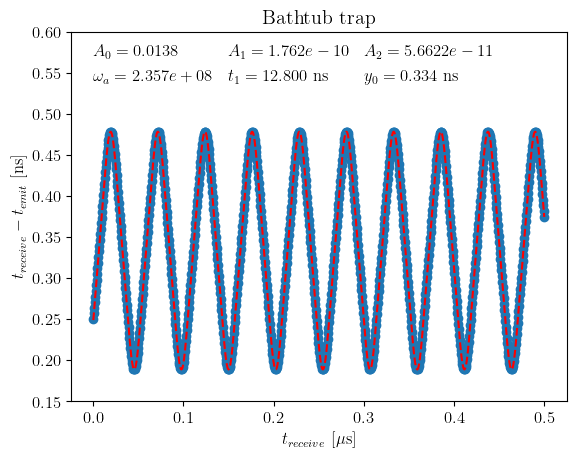

In [63]:
plt.figure()
plt.plot(arrivalTimes_bt * 1e6, (arrivalTimes_bt - timeArray) * 1e9, 'o')
plt.title("Bathtub trap")
plt.xlabel("$t_{receive}$ [$\mu$s]")
plt.ylabel("$t_{receive} - t_{emit}$ [ns]")

def DeltaTBathtub(x, A0, A1, A2, omega_a, t1, yOffset):
    t2 = t1 + np.pi / omega_a
    t3 = t1 + t2
    T = 2 * t2

    # Calculate the time modulo the axial period
    tMod = x % T
    conditions = [tMod < t1, (tMod > t1) & (tMod < t2),
                  (tMod > t2) & (tMod < t3), tMod > t3]
    choices = [A0 * tMod - A1 / 2,
               A2 * np.sin(omega_a * (tMod - t1)) + A1 / 2,
               -A0 * (tMod - t2) + A1 / 2, 
               -A2 * np.sin(omega_a * (tMod - t3)) - A1 / 2]
    return np.select(conditions, choices, default=0.0) + yOffset

# Fit the function to the bathtub trap data
wa = electron.GetSpeed() * np.sin(pitchAngleInit) / L0_bt
A0Guess = electron.GetSpeed() * np.cos(pitchAngleInit) / sc.c
A1Guess = L1_bt / 2 / sc.c
A2Guess = bathtubTrap.CalcZMax(pitchAngleInit) / sc.c
y0Guess = abs(zR) / sc.c
t1Guess = L1_bt / (electron.GetSpeed() * np.cos(pitchAngleInit))
initialGuesses = [A0Guess, A1Guess, A2Guess, wa, t1Guess, y0Guess]
popt, pcov = curve_fit(DeltaTBathtub, arrivalTimes_bt, arrivalTimes_bt - timeArray,
                       p0=initialGuesses)
plt.plot(arrivalTimes_bt * 1e6, DeltaTBathtub(arrivalTimes_bt, *popt) * 1e9, 'r--')
plt.ylim(0.15, 0.6)
# Draw the fit parameters on the plot
plt.text(0.0, 0.57, f"$A_0 = {popt[0]:.4f}$")
plt.text(0.15, 0.57, f"$A_1 = {popt[1]:.3e}$")
plt.text(0.3, 0.57, f"$A_2 = {popt[2]:.4e}$")
plt.text(0.0, 0.54, f"$\omega_a = {popt[3]:.3e}$")
plt.text(0.15, 0.54, f"$t_1 = {popt[4] * 1e9:.3f}$ ns")
plt.text(0.3, 0.54, f"$y_0 = {popt[5] * 1e9:.3f}$ ns")

plt.show()

### Now move the receiver position

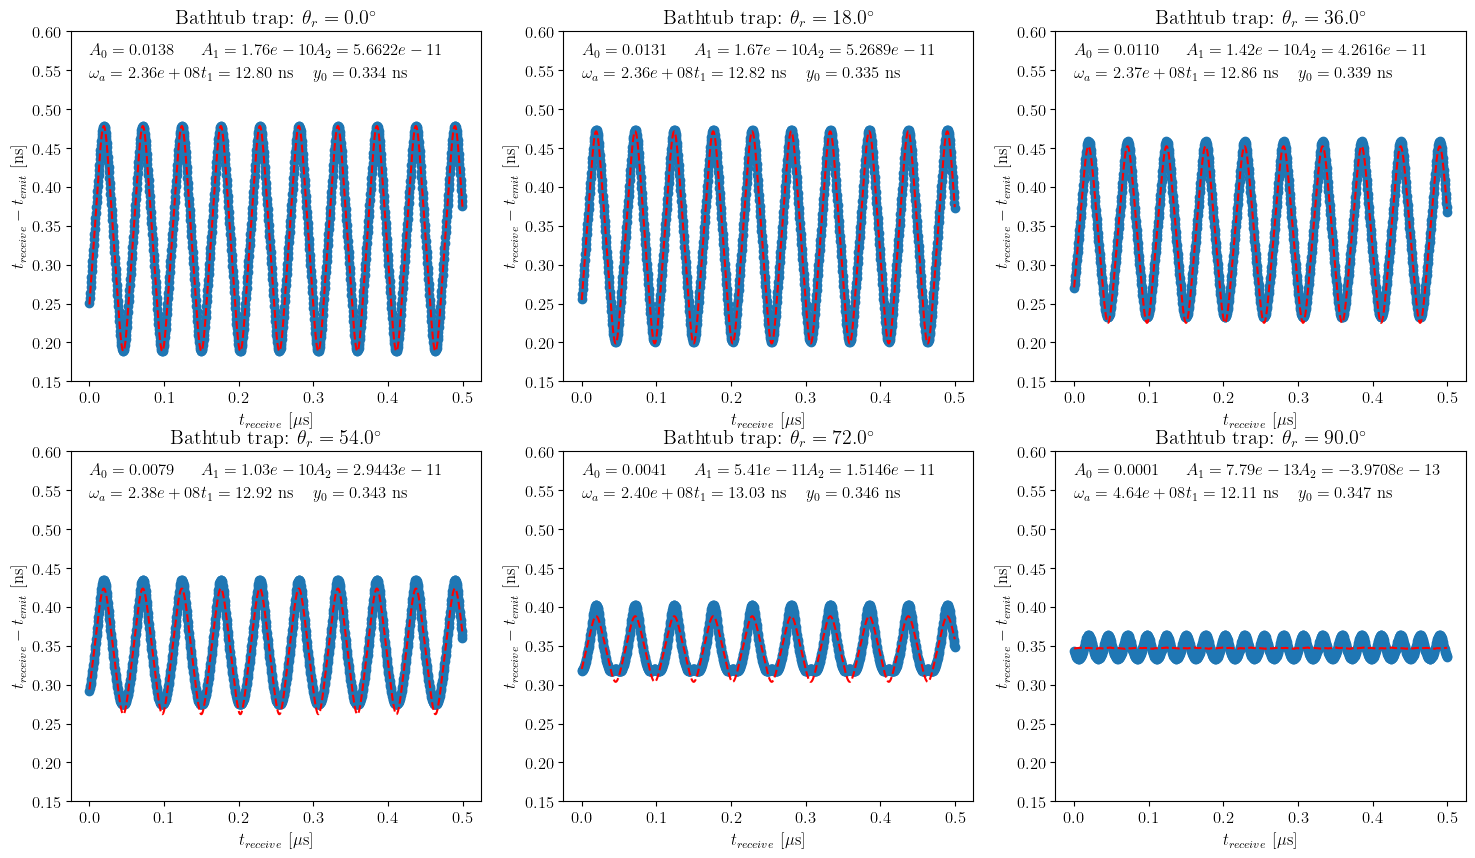

In [64]:
plt.figure(figsize=(18, 10))
for iAng, ang in enumerate(receiverAngles):
    rAngPosition = zR * np.array([np.sin(ang), 0.0, np.cos(ang)])
    aTimesAng = np.zeros_like(timeArray)
    for it, t in enumerate(timeArray):
        electronPos = np.array([0, 0, 
                                bathtubTrap.GetZPosTime(t, electron.GetSpeed(), 
                                                        pitchAngleInit)])
        aTimesAng[it] = t + np.linalg.norm(rAngPosition - electronPos) / sc.c

    plt.subplot(2, 3, iAng + 1)
    plt.plot(aTimesAng * 1e6, (aTimesAng - timeArray) * 1e9, 'o',
             label=f"{ang * 180 / np.pi:.1f}^\circ")
    plt.title(f"Bathtub trap: $\\theta_r = {ang * 180 / np.pi:.1f}^\circ$")
    plt.xlabel("$t_{receive}$ [$\mu$s]")
    plt.ylabel("$t_{receive} - t_{emit}$ [ns]")

    y0Guess = abs(zR) / sc.c
    if ang == np.pi / 2:
        wa = 2 * electron.GetSpeed() * np.sin(pitchAngleInit) / L0_bt
    else:
        wa = electron.GetSpeed() * np.sin(pitchAngleInit) / L0_bt
        
    initialGuesses = [A0Guess, A1Guess, A2Guess, wa, t1Guess, y0Guess]
    popt, pcov = curve_fit(DeltaTBathtub, aTimesAng, aTimesAng - timeArray,
                           p0=initialGuesses)
    # Draw the fit        
    fitTimes = DeltaTBathtub(aTimesAng, *popt)
    plt.plot(aTimesAng * 1e6, fitTimes * 1e9, 'r--')
    # Draw the fit parameters on each plote
    plt.ylim(0.15, 0.6)
    plt.text(0.0, 0.57, f"$A_0 = {popt[0]:.4f}$")
    plt.text(0.15, 0.57, f"$A_1 = {popt[1]:.2e}$")
    plt.text(0.3, 0.57, f"$A_2 = {popt[2]:.4e}$")
    plt.text(0.0, 0.54, f"$\omega_a = {popt[3]:.2e}$")
    plt.text(0.15, 0.54, f"$t_1 = {popt[4] * 1e9:.2f}$ ns")
    plt.text(0.3, 0.54, f"$y_0 = {popt[5] * 1e9:.3f}$ ns")

plt.show()